In [1]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from impedance import preprocessing
from impedance.models.circuits.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

In [2]:
file_dir = r"A:\BrianGerwe\Research\COMSOL\PatternedFilm_Potentiodynamic\Table Exports\Fluxes\NoHole_Pinholes"

# We need to treat data flagged "N-0" differently, since they represent a film without a mask
# Therefore the impedance is calculated a little different in COMSOL
match_str = "\G-5_N-[1-9]*10pt-dec.csv"
all_files = glob.glob(file_dir+match_str)
all_files.sort(key=lambda x: x.split("_N-")[-1].split("_")[0])

n0_file = glob.glob(file_dir+"\G-5_N-0*10pt-dec.csv")

In [3]:
dat_n0 = pd.read_csv(n0_file[0], skiprows=4)

f_n0 = np.array(dat_n0['% f'])
Z_raw = dat_n0['impedance from LT holes_mask (s^3/(kg*m^2))']
Z_n0 = np.array([complex(s.replace('i','j')) for s in Z_raw])

print(len(f_n0), len(Z_n0))
f_n0, Z_n0 = preprocessing.ignoreBelowX(f_n0, Z_n0)
f_n0, Z_n0 = f_n0[::-1], Z_n0[::-1]
print(len(f_n0), len(Z_n0))

132 132
103 103


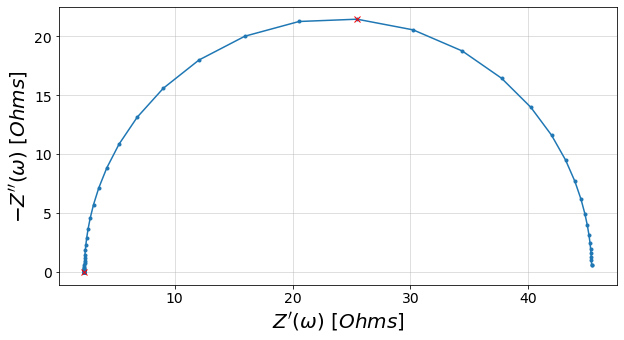

In [4]:
_, ax =plt.subplots(figsize=(10,10))

plot_nyquist(ax, Z_n0)
plot_nyquist(ax, Z_n0[signal.find_peaks(-Z_n0.imag)[0]], fmt='rx')
plt.show()

In [5]:
circ_str = "R0-p(R1,C1)"

R0_init = Z_n0[0].real

f1 = f_n0[np.argmin(Z_n0.imag)]
R1_init = (Z_n0[-1] - Z_n0[0]).real
C1_init = 1 / (2 * np.pi * f1 * R1_init)

inits = [R0_init, R1_init, C1_init]
circ = CustomCircuit(circuit=circ_str, initial_guess=inits)
circ.fit(f_n0, Z_n0)
print(circ)


Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 2.32e+00 [Ohm]
     R1 = 4.30e+01 [Ohm]
     C1 = 5.86e-02 [F]

Fit parameters:
     R0 = 2.33e+00  (+/- 1.29e-03) [Ohm]
     R1 = 4.30e+01  (+/- 3.07e-03) [Ohm]
     C1 = 5.43e-02  (+/- 1.05e-05) [F]



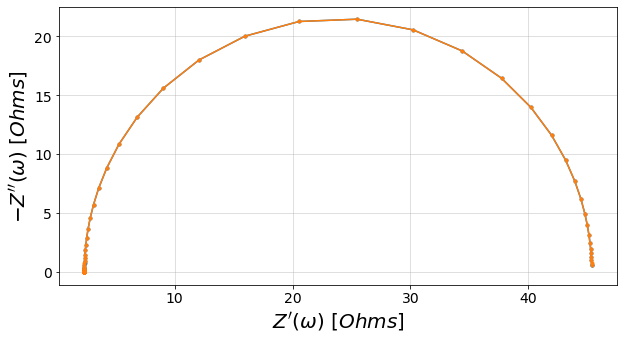

In [6]:
_, ax =plt.subplots(figsize=(10,10))

plot_nyquist(ax, Z_n0)
plot_nyquist(ax, circ.predict(f_n0))
plt.show()

In [8]:
def process_n0(file_name, return_Z=False):
    dat_n0 = pd.read_csv(n0_file[0], skiprows=4)

    f_n0 = np.array(dat_n0['% f'])
    Z_raw = dat_n0['impedance from LT holes_mask (s^3/(kg*m^2))']
    Z_n0 = np.array([complex(s.replace('i','j')) for s in Z_raw])

    print(len(f_n0), len(Z_n0))
    f_n0, Z_n0 = preprocessing.ignoreBelowX(f_n0, Z_n0)
    f_n0, Z_n0 = f_n0[::-1], Z_n0[::-1]
    print(len(f_n0), len(Z_n0))
    
    circ_str = "R0-p(R1,C1)"

    R0_init = Z_n0[0].real

    f1 = f_n0[np.argmin(Z_n0.imag)]
    R1_init = (Z_n0[-1] - Z_n0[0]).real
    C1_init = 1 / (2 * np.pi * f1 * R1_init)

    inits = [R0_init, R1_init, C1_init]
    circ = CustomCircuit(circuit=circ_str, initial_guess=inits)
    circ.fit(f_n0, Z_n0)
    print(circ)
    
    _, ax =plt.subplots(figsize=(10,10))

    plot_nyquist(ax, Z_n0)
    plot_nyquist(ax, circ.predict(f_n0))
    plt.show()
    
    if return_Z:
        return f_n0, Z_n0, circ
    else:
        return 

132 132
103 103

Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 2.32e+00 [Ohm]
     R1 = 4.30e+01 [Ohm]
     C1 = 5.86e-02 [F]

Fit parameters:
     R0 = 2.33e+00  (+/- 1.29e-03) [Ohm]
     R1 = 4.30e+01  (+/- 3.07e-03) [Ohm]
     C1 = 5.43e-02  (+/- 1.05e-05) [F]



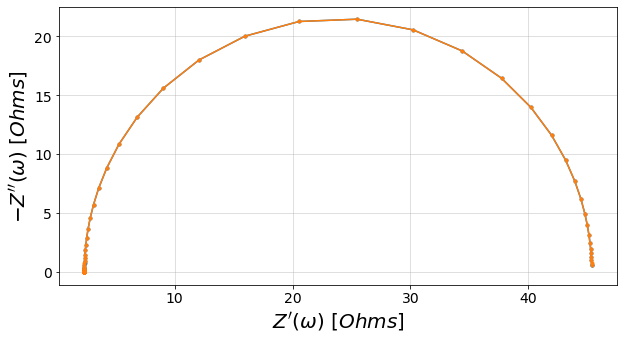

In [9]:
n0_file = glob.glob(file_dir+"\G-5_N-0*10pt-dec.csv")

process_n0(n0_file)

## Now do it for the rest

In [7]:
def extract_Z(dat):
    f = np.array(dat['% f'])
    Z_raw = dat['impedance from LT gate (s^3/(kg*m^2))']
    Z = np.array([complex(s.replace('i','j')) for s in Z_raw])

    f, Z = preprocessing.ignoreBelowX(f, Z)
    f, Z = f[::-1], Z[::-1]

    return f, Z

def get_inits(f, Z):
    peak_inds = signal.find_peaks(-Z.imag)[0]

    R1_ind = peak_inds[0]+np.argmax(Z[peak_inds[0]:peak_inds[1]].imag)
    R1_init = Z[R1_ind].real - Z[0].real

    f_1 = f[peak_inds[0]]
    C1_init = 1 / (2 * np.pi * f_1 * R1_init)

    R2_init = Z[-1].real - Z[R1_ind].real

    f_2 = f[peak_inds[1]]
    C2_init = 1 / (2 * np.pi * f_2 * R2_init)

    inits = [Z[0].real, R1_init, C1_init, 0.5, R2_init, C2_init]
    
    return inits

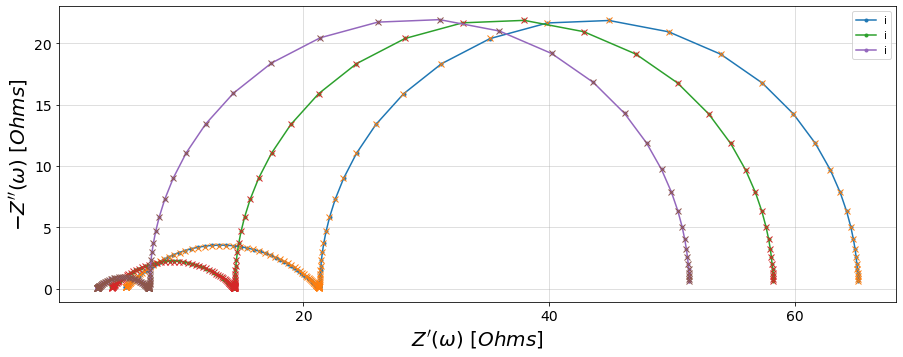

In [8]:
fs, Zs, circs = [], [], []

_, ax = plt.subplots(figsize=(15,10))

for i, file in enumerate(all_files):
    dat = pd.read_csv(file, skiprows=4)
    
    f, Z = extract_Z(dat)
    fs.append(f)
    Zs.append(Z)
    plot_nyquist(ax, Z, label='i')
    
    circ_str = "R0-p(R1,CPE1)-p(R2,C2)"
    inits = get_inits(f, Z)
    circ = CustomCircuit(circuit=circ_str, initial_guess=inits)
    circ.fit(f, Z)
    circs.append(circ)
    
    plot_nyquist(ax, circ.predict(f), fmt='x')

ax.legend()
plt.show()

# Now do it for G=0.5 files

In [9]:
file_dir = r"A:\BrianGerwe\Research\COMSOL\PatternedFilm_Potentiodynamic\Table Exports\Fluxes\NoHole_Pinholes"

# We need to treat data flagged "N-0" differently, since they represent a film without a mask
# Therefore the impedance is calculated a little different in COMSOL
G = r"\G-0_5"
match_str = "_N-[1-9]*10pt-dec.csv"
all_files = glob.glob(file_dir+G+match_str)
all_files.sort(key=lambda x: x.split("_N-")[-1].split("_")[0])

n0_file = glob.glob(file_dir+G+"_N-0*10pt-dec.csv")

In [10]:
dat_n0 = pd.read_csv(n0_file[0], skiprows=4)

f_n0 = np.array(dat_n0['% f'])
Z_raw = dat_n0['impedance from LT holes_mask (s^3/(kg*m^2))']
Z_n0 = np.array([complex(s.replace('i','j')) for s in Z_raw])

print(len(f_n0), len(Z_n0))
f_n0, Z_n0 = preprocessing.ignoreBelowX(f_n0, Z_n0)
f_n0, Z_n0 = f_n0[::-1], Z_n0[::-1]
print(len(f_n0), len(Z_n0))

132 132
112 112


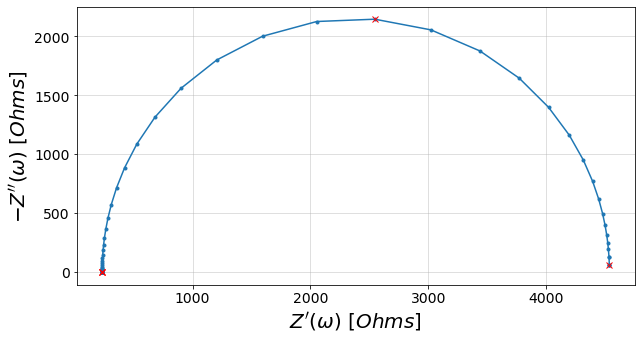

In [11]:
_, ax =plt.subplots(figsize=(10,10))

plot_nyquist(ax, Z_n0)
plot_nyquist(ax, Z_n0[signal.find_peaks(-Z_n0.imag)[0]], fmt='rx')
plt.show()

In [12]:
circ_str = "R0-p(R1,C1)"

R0_init = Z_n0[0].real

f1 = f_n0[np.argmin(Z_n0.imag)]
R1_init = (Z_n0[-1] - Z_n0[0]).real
C1_init = 1 / (2 * np.pi * f1 * R1_init)

inits = [R0_init, R1_init, C1_init]
circ = CustomCircuit(circuit=circ_str, initial_guess=inits)
circ.fit(f_n0, Z_n0)
print(circ)


Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 2.32e+02 [Ohm]
     R1 = 4.30e+03 [Ohm]
     C1 = 5.86e-04 [F]

Fit parameters:
     R0 = 2.33e+02  (+/- 3.68e-01) [Ohm]
     R1 = 4.30e+03  (+/- 9.16e-01) [Ohm]
     C1 = 5.43e-04  (+/- 3.14e-07) [F]



No handles with labels found to put in legend.


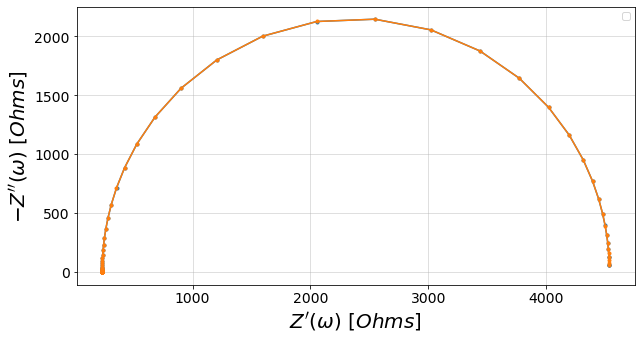

In [13]:
_, ax =plt.subplots(figsize=(10,10))

plot_nyquist(ax, Z_n0)
plot_nyquist(ax, circ.predict(f_n0))
ax.legend()
plt.show()

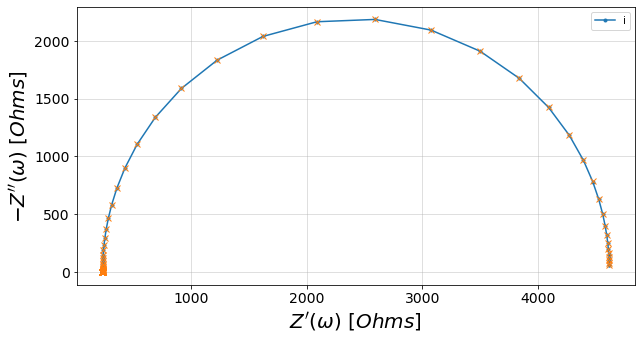

In [14]:
fs, Zs, circs = [], [], []

_, ax = plt.subplots(figsize=(10,7))

for i, file in enumerate(all_files):
    dat = pd.read_csv(file, skiprows=4)
    
    f, Z = extract_Z(dat)
    fs.append(f)
    Zs.append(Z)
    plot_nyquist(ax, Z, label='i')
    
    circ_str = "R0-p(R1,CPE1)-p(R2,C2)"
    inits = get_inits(f, Z)
    circ = CustomCircuit(circuit=circ_str, initial_guess=inits)
    circ.fit(f, Z)
    circs.append(circ)
    
    plot_nyquist(ax, circ.predict(f), fmt='x')
    
ax.legend()
plt.show()

In [15]:
for i, circ in enumerate(circs):
    print(i, circ)

0 
Circuit string: R0-p(R1,CPE1)-p(R2,C2)
Fit: True

Initial guesses:
     R0 = 2.33e+02 [Ohm]
     R1 = 3.70e+00 [Ohm]
  CPE1_0 = 2.16e-08 [Ohm^-1 sec^a]
  CPE1_1 = 5.00e-01 []
     R2 = 4.38e+03 [Ohm]
     C2 = 5.76e-04 [F]

Fit parameters:
     R0 = 2.33e+02  (+/- 3.19e-01) [Ohm]
     R1 = 4.23e+00  (+/- 3.93e-01) [Ohm]
  CPE1_0 = 1.21e-04  (+/- 1.75e-04) [Ohm^-1 sec^a]
  CPE1_1 = 4.68e-01  (+/- 9.59e-02) []
     R2 = 4.38e+03  (+/- 3.13e-01) [Ohm]
     C2 = 5.34e-04  (+/- 1.02e-07) [F]

